<center> <H1>EE 610: Assignment 2 </H1></center>
<center> <H2>Name: Vinit Awale</H2></center>
<center> <H2>Roll No. 18D070067</H2></center>

## IMPORTS

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

## Hyperparameters

In [32]:
size = 321

## Question 2
### Part a)

We select the largest window size W = 13

In [33]:
W = int(13)


### Part b)

We use the following blur kernels of size W = 13
- simple blur kernel
- gaussian blur kernel
- median blur kernel

In [34]:
blurs = [cv2.blur , cv2.GaussianBlur , cv2.medianBlur]

The noise models that we use are the following:
- Gaussian noise with mean 0 
- Salt and pepper noise with probability 0.05

In [35]:
Gaussian_noise = np.random.normal(0, 0.1, (size,size,3)) * 25
Gaussian_noise = np.uint8(Gaussian_noise)
Salt_and_pepper_noise = np.random.randint(-1, 2, (size,size,3)) * 10
Salt_and_pepper_noise = np.uint8(Salt_and_pepper_noise)

Let us visualize the noise models.

Text(0.5, 1.0, 'Gaussian Noise')

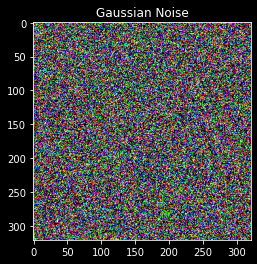

In [36]:
plt.imshow(Gaussian_noise)
plt.title('Gaussian Noise')

Text(0.5, 1.0, 'Salt and Pepper Noise')

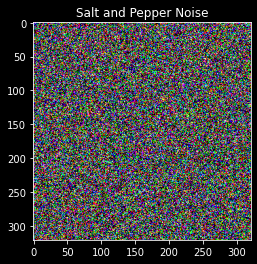

In [37]:
plt.imshow(Salt_and_pepper_noise)
plt.title('Salt and Pepper Noise')

In [38]:
noises = [Gaussian_noise, Salt_and_pepper_noise]

In [39]:
# Load training images and resize them to 321x321
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (321, 321))
        if img is not None:
            images.append(img)
    return images

path = "BSDS300\\images\\train"
images = load_images(path)

### Part c)

In [40]:
degraded_images = []

for i in range(len(images)):
    img = np.uint8(images[i])
    for _ in range(2):
        # Randomly select a blur function index
        blur_index = np.random.randint(0, len(blurs))

        if blur_index == 0:
            img = blurs[0](img, (W,W))
        elif blur_index == 1:
            img = blurs[1](img, ksize = (W,W), sigmaX = W)
        elif blur_index == 2:
            img = blurs[2](img, W)

        # Randomly select a noise function index from 0 or 1
        noise_func = noises[np.random.randint(0, 2)]
        
        # Add noise to the blurred image
        img = img + noise_func
    
    img = np.clip(img, 0, 255).astype(np.uint8)   # Clip and convert to uint8
    
    # Add the blurred and noisy image to the list of degraded images
    degraded_images.append(img)


### Visulaization of the degraded images

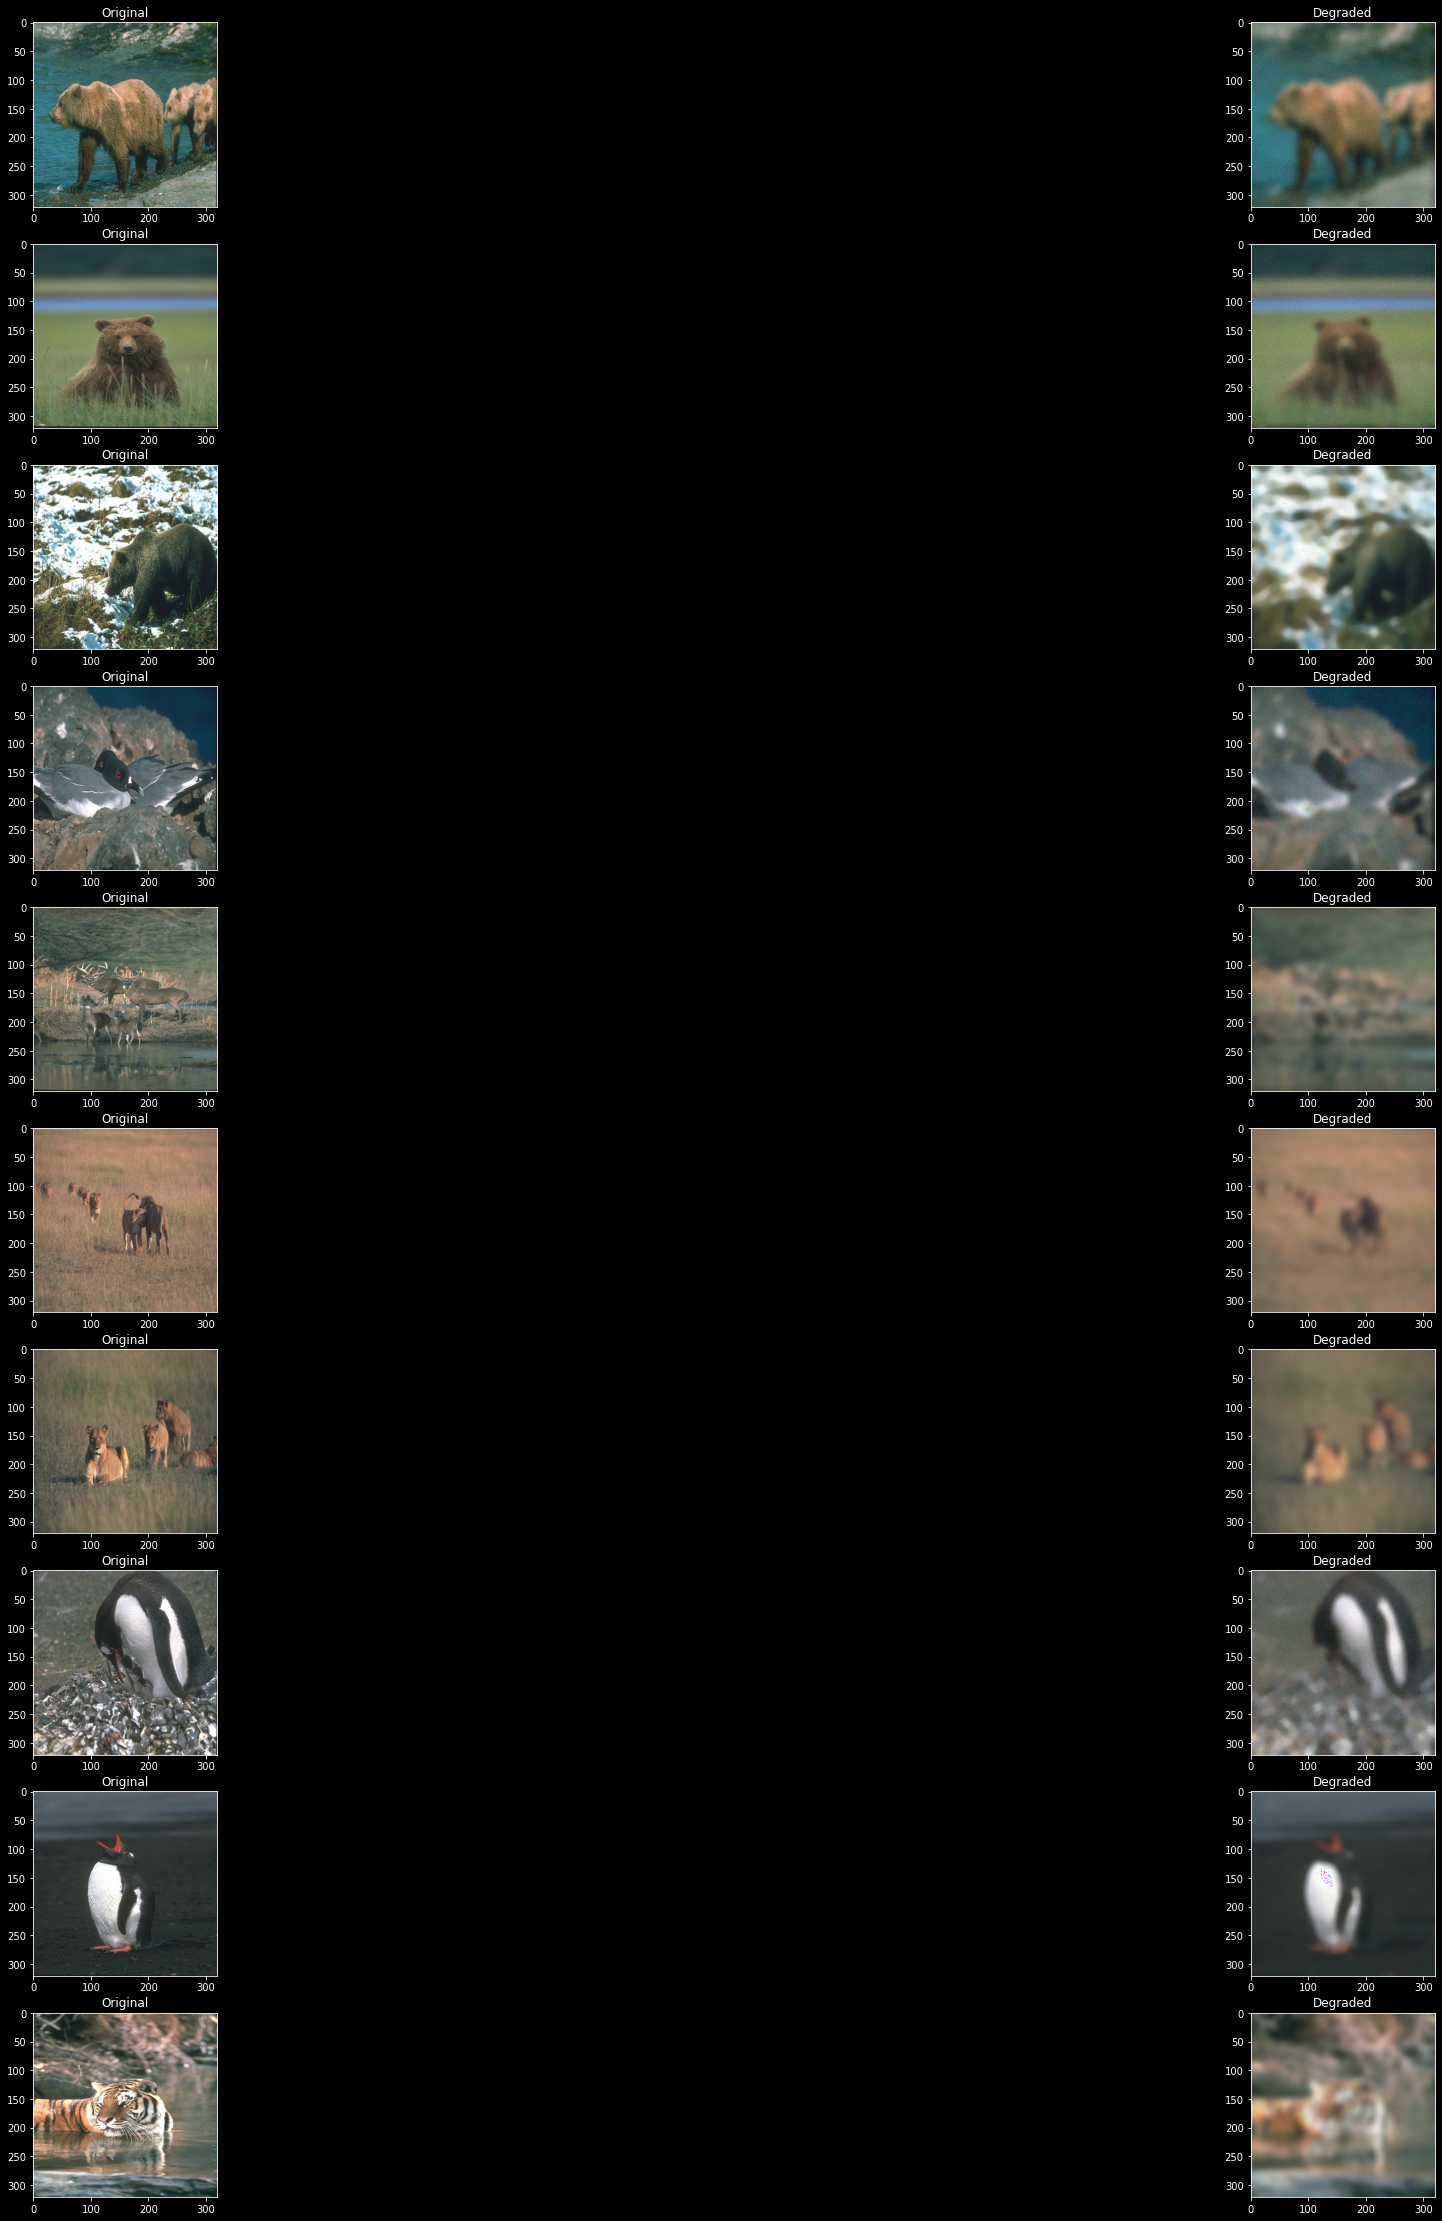

In [41]:
# Display the first 10 degraded images along with their original images
plt.figure(figsize=(40,40))
for i in range(10):
    plt.subplot(10,2,2*i+1)
    plt.imshow(images[i])
    plt.title('Original')
    plt.subplot(10,2,2*i+2)
    plt.imshow(degraded_images[i])
    plt.title('Degraded')
    

### Zoomed in on the following images to see the degradation.

Text(0.5, 1.0, 'Original')

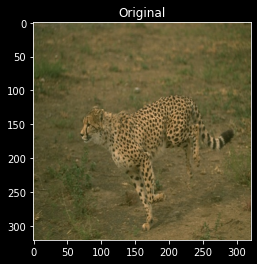

In [42]:
plt.imshow(images[25])
plt.title('Original')


Text(0.5, 1.0, 'Degraded')

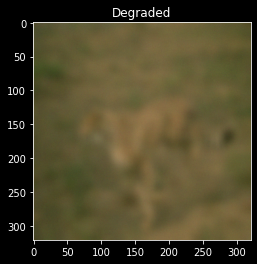

In [43]:
plt.imshow(degraded_images[25])
plt.title('Degraded')

### Hence, we can see that there is a clear degradation in the images.

### Extracting patches from the degraded images of size W = 13

In [83]:
## Extracting k random patches from the degraded images of size (W,W) and getting the central pixel of the patch from the original image for an image index

def get_random_patches(img_index, W, k):
    """ Function to get k random patches from the degraded images of size (W,W) and getting the central pixel of the patch from the original image for an image index

    Args:
        img_index (int): Index of the image from which the patches are to be extracted
        W (int): Width of the patch
        k (int): Number of patches to be extracted

    Returns:
        ndarray: Array of shape (k, W, W, 3) containing the k patches
    """
    patches = []
    central_pixels = []

    for i in range(0, img.shape[0] - W, W):
        for j in range(0, img.shape[1] - W, W):
            patch = degraded_images[img_index][i:i+W, j:j+W, :]
            patches.append(patch)
            central_pixels.append(images[img_index][i+W//2, j+W//2, :])


    # k random number from 1 to patches.shape[0]
    random_indices = np.random.randint(0, len(patches), k)

    # Randomly select k patches from the list of patches
    random_patches = [patches[i] for i in random_indices]
    random_central_pixels = [central_pixels[i] for i in random_indices]
    
    random_patches = np.array(random_patches)
    random_central_pixels = np.array(random_central_pixels)
    random_central_pixels = random_central_pixels.reshape(k,1,1,3)

    return random_patches, random_central_pixels

### Visualizing one of the patches and the corresponding center of the patch

In [84]:
patch, pixel =  get_random_patches(0, W, 10)

Text(0.5, 1.0, 'Random Patch')

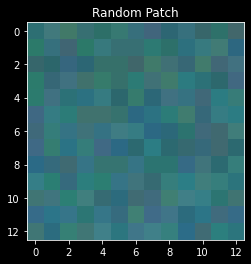

In [85]:
plt.imshow(patch[9])
plt.title('Random Patch')

Text(0.5, 1.0, 'Central Pixel of original image')

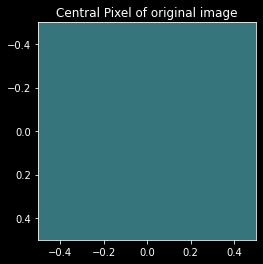

In [87]:
plt.imshow(pixel[9])
plt.title('Central Pixel of original image')

### Making patches of size W = 13 from the degraded images and the corresponding center of the patch

In [95]:
patches = []
central_pixels = []

for i in range(len(degraded_images)):
    patch, pixel = get_random_patches(i, W, 10)
    patches.append(patch)
    central_pixels.append(pixel)

patches = np.array(patches)
central_pixels = np.array(central_pixels)

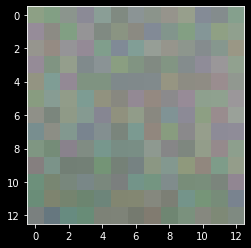

In [98]:
plt.imshow(patches[0][0])

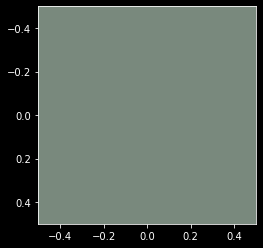

In [96]:
plt.imshow(central_pixels[0][0])

In [97]:
patches.shape

(200, 10, 13, 13, 3)

## Question 3

### Part a) We select w = 11

In [100]:
w = 11

### Part b) We use random forest regression to train the model

### Part c) 

In [113]:
## Function to read wxw patches from the degraded images and get the central pixel of the patch from the original image for an image index

def get_small_patches(patch,W, w):
    return patch[(W-w)//2:(W-w)//2+w, (W-w)//2:(W-w)//2+w, :]


### Visualizing a small patch of the degraded image

In [117]:
small_patch =  get_small_patches(patches[0][0], W, w)

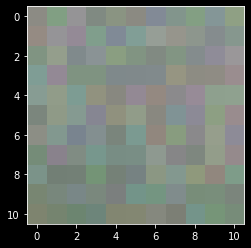

In [118]:
plt.imshow(small_patch)